---
title: NA CORDEX diagnostic plots
author: Harsha R. Hampapura
date: 2026-02-11
---

- This notebook is adapted from the NA CORDEX notebook on AWS
- http://ncar-aws-www.s3-website-us-west-2.amazonaws.com/plot-zarr-diagnostics.html

### Input Data Access
- This notebook illustrates how to make diagnostic plots using the NA-CORDEX dataset hosted on NCAR's Geoscience Data Exchange (GDEX)
- https://gdex.ucar.edu/datasets/d316010/
- This data is open access and can be accessed via 2 protocols
- 1) HTTPS (if you have access to NCAR's HPC)
- 2) OSDF using an intake-ESM catalog.

In [1]:
# Imports
import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import re
import matplotlib.pyplot as plt
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import os

In [3]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [4]:
# catalog_url = 'https://osdf-data.gdex.ucar.edu/ncar-gdex/d316010/catalogs/d316010-osdf-zarr.json'
catalog_url = 'https://osdata.gdex.ucar.edu/d316010/catalogs/d316010-osdf.json' #NCAR's Object store
print(catalog_url)

https://osdata.gdex.ucar.edu/d316010/catalogs/d316010-osdf.json


In [5]:
# Set up your scratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)

/glade/derecho/scratch/harshah


## Create a PBS cluster

In [6]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = glade_scratch+'/dask/spill',
    log_directory = glade_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/u/home/harshah/.conda/envs/osdf/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34989 instead
  warnings.warn(


In [7]:
# Create the client to load the Dashboard
client = Client(cluster)
n_workers = 8
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(4c1bdbe9, 'tcp://128.117.208.68:35631', workers=8, threads=8, memory=64.00 GiB)

## Load NA CORDEX data from GDEX using an intake catalog

In [8]:
col = intake.open_esm_datastore(catalog_url)
col

,unique
,330
variable,15
standard_name,10
long_name,18
units,10
spatial_domain,1
grid,2
spatial_resolution,2
scenario,6
start_time,3


### Load data into xarray

In [10]:
data_var = 'tmax'

col_subset = col.search(
    variable=data_var,
    grid="NAM-44i",
    scenario="eval",
    bias_correction="raw",
)

col_subset

,unique
column_0,1
variable,1
standard_name,1
long_name,1
units,1
spatial_domain,1
grid,1
spatial_resolution,1
scenario,1
start_time,1


In [11]:
col_subset.df['path'].values

<ArrowExtensionArray>
['osdf:////ncar-gdex/d316010/day/tmax.eval.day.NAM-44i.raw.zarr']
Length: 1, dtype: large_string[pyarrow]

In [12]:
col_subset['tmax.day.eval.NAM-44i.raw'].df

,,variable,standard_name,long_name,units,spatial_domain,grid,spatial_resolution,scenario,start_time,end_time,frequency,vertical_levels,bias_correction,na-cordex-models,path,_data_format_
0,223,tmax,air_temperature,Daily Maximum Near-Surface Air Temperature,degC,north_america,NAM-44i,0.50 deg,eval,1979-01-01T12:00:00,2015-12-31T12:00:00,day,1,raw,"['ERA-Int.CRCM5-UQAM', 'ERA-Int.RegCM4', 'ERA-...",osdf:////ncar-gdex/d316010/day/tmax.eval.day.N...,zarr


In [14]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True,'zarr_format':2})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.scenario.grid.bias_correction'


<div><progress max="1" value="1"></progress> 100.00% [1/1 00:04&lt;00:00]</div>


Dataset dictionary keys:
 dict_keys(['tmax.day.eval.NAM-44i.raw'])


In [15]:
# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
store_name = dataset_key + ".zarr"

ds = dsets[dataset_key]
ds

<xarray.Dataset> Size: 13GB
Dimensions:    (member_id: 6, time: 13514, lat: 129, lon: 300, bnds: 2)
Coordinates:
  * member_id  (member_id) <U18 432B 'ERA-Int.CRCM5-UQAM' ... 'ERA-Int.WRF'
  * time       (time) datetime64[ns] 108kB 1979-01-01T12:00:00 ... 2015-12-31...
  * lat        (lat) float64 1kB 12.25 12.75 13.25 13.75 ... 75.25 75.75 76.25
  * lon        (lon) float64 2kB -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
    time_bnds  (time, bnds) datetime64[ns] 216kB dask.array<chunksize=(13514, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tmax       (member_id, time, lat, lon) float32 13GB dask.array<chunksize=(3, 1000, 65, 150), meta=np.ndarray>
Attributes: (12/43)
    CORDEX_domain:                        NAM-44
    contact:                              {"ERA-Int.CRCM5-UQAM": "Winger.Katj...
    contact_note:                         {"ERA-Int.RegCM4": "Simulations by ...
    creation_date:                        {"ERA-Int.CRCM5-UQAM": "2015-06-18T...
    driving_experiment:                   {"ERA-Int.CRCM5-UQAM": "ECMWF-ERAIN...
    driving_experiment_name:              evaluation
    ...                                   ...
    intake_esm_attrs:vertical_levels:     1
    intake_esm_attrs:bias_correction:     raw
    intake_esm_attrs:na-cordex-models:    ['ERA-Int.CRCM5-UQAM', 'ERA-Int.Reg...
    intake_esm_attrs:path:                osdf:////ncar-gdex/d316010/day/tmax...
    intake_esm_attrs:_data_format_:       zarr
    intake_esm_dataset_key:               tmax.day.eval.NAM-44i.raw

### Functions for Plotting

#### Helper Function to Create a Single Map Plot

In [16]:
def plotMap(ax, map_slice, date_object=None, member_id=None):
    """Create a map plot on the given axes, with min/max as text"""

    ax.imshow(map_slice, origin='lower')

    minval = map_slice.min(dim = ['lat', 'lon'])
    maxval = map_slice.max(dim = ['lat', 'lon'])

    # Format values to have at least 4 digits of precision.
    ax.text(0.01, 0.03, "Min: %3g" % minval, transform=ax.transAxes, fontsize=12)
    ax.text(0.99, 0.03, "Max: %3g" % maxval, transform=ax.transAxes, fontsize=12, horizontalalignment='right')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if date_object:
        ax.set_title(date_object.values.astype(str)[:10], fontsize=12)
        
    if member_id:
        ax.set_ylabel(member_id, fontsize=12)
        
    return ax

#### Helper Function for Finding Dates with Available Data

In [17]:
def getValidDateIndexes(member_slice):
    """Search for the first and last dates with finite values."""
    min_values = member_slice.min(dim = ['lat', 'lon'])
    is_finite = np.isfinite(min_values)
    finite_indexes = np.where(is_finite)

    start_index = finite_indexes[0][0]
    end_index = finite_indexes[0][-1]
    return start_index, end_index

#### Function Producing Maps of First, Middle, and Final Timesteps

In [18]:
def plot_first_mid_last(ds, data_var, store_name):
    """Plot the first, middle, and final time steps for several climate runs."""
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]
    
    figWidth = 18 
    figHeight = 12 
    numPlotColumns = 3
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
           
        start_index, end_index = getValidDateIndexes(data_slice)
        midDateIndex = np.floor(len(ds.time) / 2).astype(int)

        startDate = ds.time[start_index]
        first_step = data_slice.sel(time=startDate) 
        ax = axs[index, 0]
        plotMap(ax, first_step, startDate, mem_id)

        midDate = ds.time[midDateIndex]
        mid_step = data_slice.sel(time=midDate)   
        ax = axs[index, 1]
        plotMap(ax, mid_step, midDate)

        endDate = ds.time[end_index]
        last_step = data_slice.sel(time=endDate)            
        ax = axs[index, 2]
        plotMap(ax, last_step, endDate)
        
        plt.suptitle(f'First, Middle, and Last Timesteps for Selected Runs in "{store_name}"', fontsize=20)

    return fig

#### Function Producing Statistical Map Plots

In [19]:
def plot_stat_maps(ds, data_var, store_name):
    """Plot the mean, min, max, and standard deviation values for several climate runs, aggregated over time."""
    
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 12 
    numPlotColumns = 4
    
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)

        data_agg = data_slice.min(dim='time')
        plotMap(axs[index, 0], data_agg, member_id=mem_id)

        data_agg = data_slice.max(dim='time')
        plotMap(axs[index, 1], data_agg)

        data_agg = data_slice.mean(dim='time')
        plotMap(axs[index, 2], data_agg)

        data_agg = data_slice.std(dim='time')
        plotMap(axs[index, 3], data_agg)

    axs[0, 0].set_title(f'min({data_var})', fontsize=15)
    axs[0, 1].set_title(f'max({data_var})', fontsize=15)
    axs[0, 2].set_title(f'mean({data_var})', fontsize=15)
    axs[0, 3].set_title(f'std({data_var})', fontsize=15)

    plt.suptitle(f'Spatial Statistics for Selected Runs in "{store_name}"', fontsize=20)

    return fig

#### Function Producing Time Series Plots

Also show which dates have no available data values, as a rug plot.

In [20]:
def plot_timeseries(ds, data_var, store_name):
    """Plot the mean, min, max, and standard deviation values for several climate runs, 
       aggregated over lat/lon dimensions."""

    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 20
    linewidth = 0.5

    numPlotColumns = 1
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight))
        
    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
        unit_string = ds[data_var].attrs['units']
        
        min_vals = data_slice.min(dim = ['lat', 'lon'])
        max_vals = data_slice.max(dim = ['lat', 'lon'])
        mean_vals = data_slice.mean(dim = ['lat', 'lon'])
        std_vals = data_slice.std(dim = ['lat', 'lon'])

        missing_indexes = np.isnan(min_vals)
        missing_times = ds.time[missing_indexes]

            
        axs[index].plot(ds.time, max_vals, linewidth=linewidth, label='max', color='red')
        axs[index].plot(ds.time, mean_vals, linewidth=linewidth, label='mean', color='black')
        axs[index].fill_between(ds.time, (mean_vals - std_vals), (mean_vals + std_vals), 
                                         color='grey', linewidth=0, label='std', alpha=0.5)
        axs[index].plot(ds.time, min_vals, linewidth=linewidth, label='min', color='blue')
            
        ymin, ymax = axs[index].get_ylim()
        rug_y = ymin + 0.01*(ymax-ymin)
        axs[index].plot(missing_times, [rug_y]*len(missing_times), '|', color='m', label='missing')
        axs[index].set_title(mem_id, fontsize=20)
        axs[index].legend(loc='upper right')
        axs[index].set_ylabel(unit_string)

    plt.tight_layout(pad=10.2, w_pad=3.5, h_pad=3.5)
    plt.suptitle(f'Temporal Statistics for Selected Runs in "{store_name}"', fontsize=20)

    return fig

### Produce Diagnostic Plots

#### Plot First, Middle, and Final Timesteps for Several Output Runs (less compute intensive)


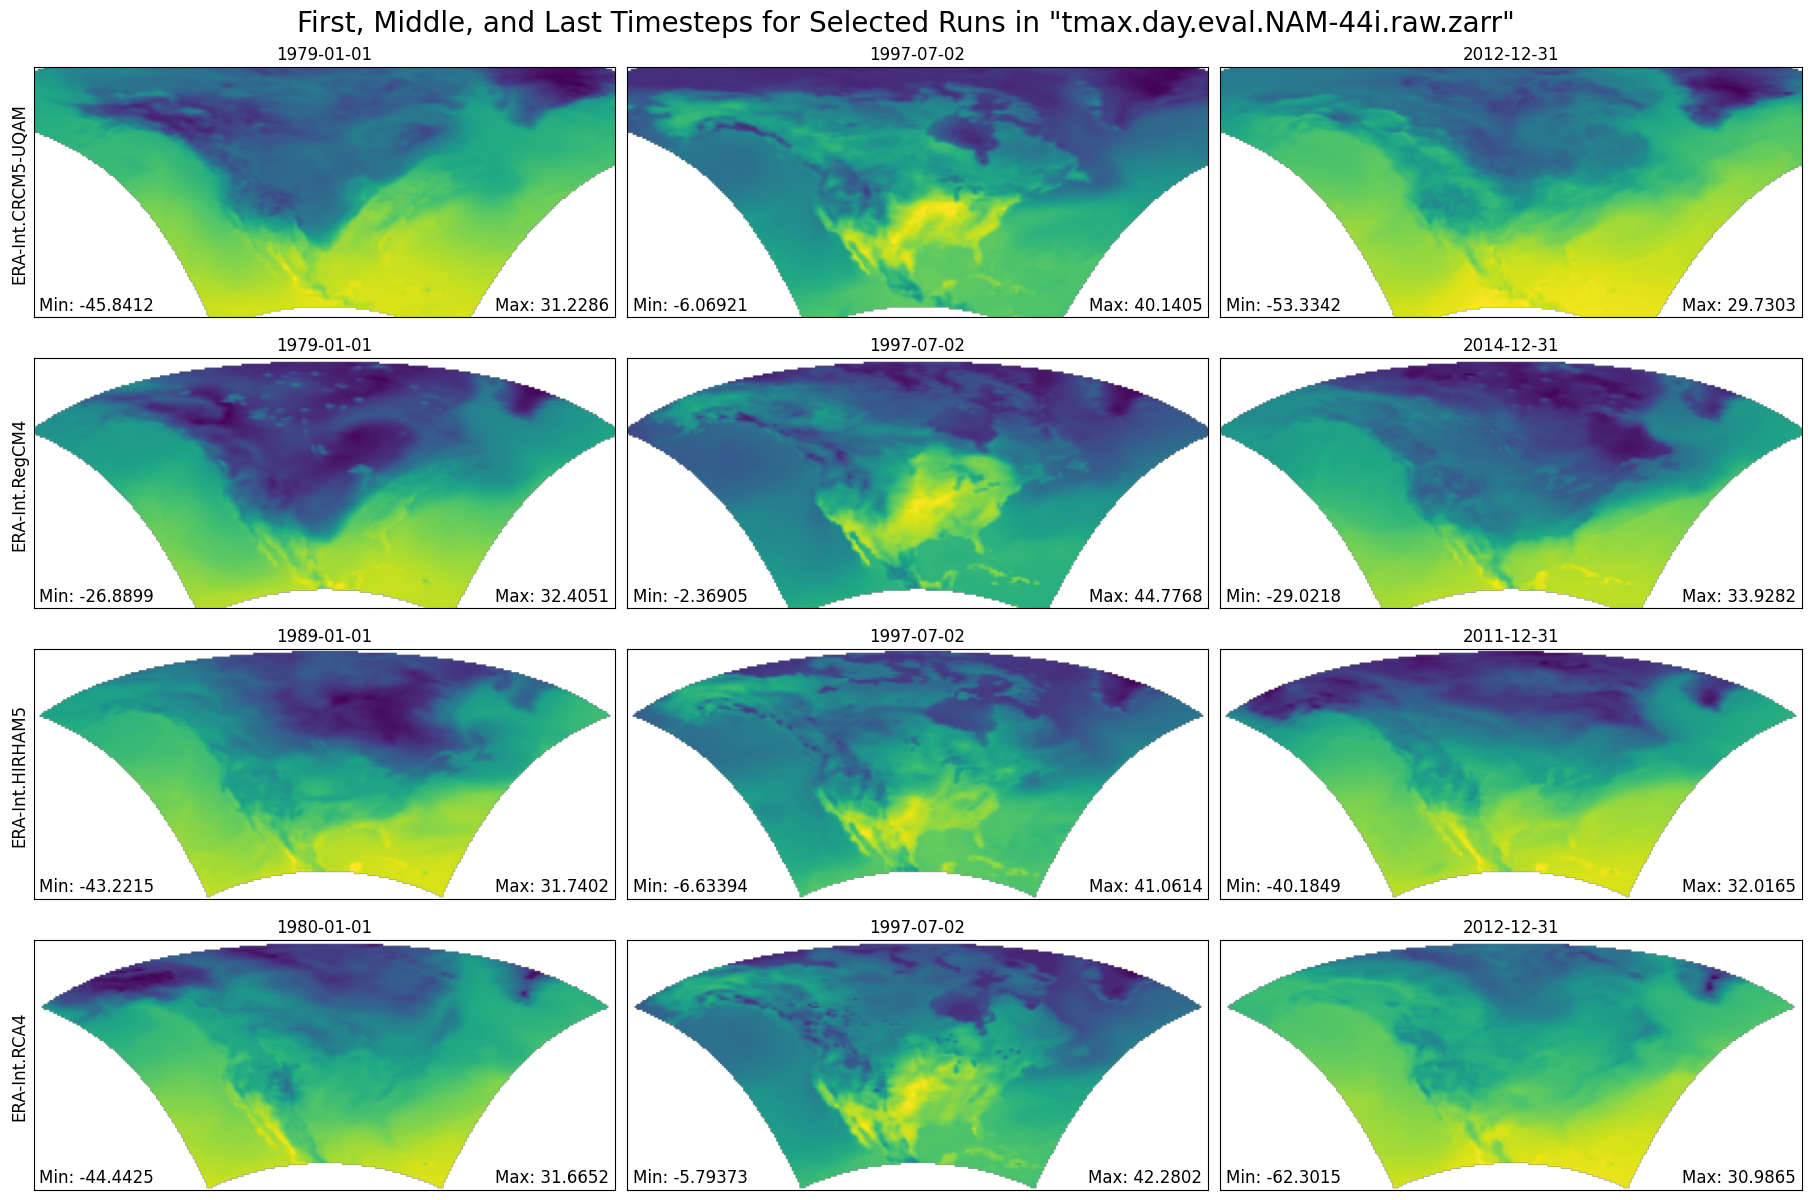

CPU times: user 2.48 s, sys: 221 ms, total: 2.7 s
Wall time: 44.7 s


In [21]:
%%time
# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_first_mid_last(ds, data_var, store_name)

plt.show()

In [22]:
cluster.close()